# Introduction: Business Problem

Kolkata is considered one of the largest cities in India. It is among the top metro cities in India and is the capital of West Bengal.
Nowadays, the hotel management industry is becoming one of the
leading industries among all. 
This project deals with the major venue categories in the neighborhoods of Kolkata.

Our aim is to find the best location to open a **hotel**,**fast food restaurant**, **pizza place** and **multiplex** in the city of joy, Kolkata, to maximize the profit of the owner.   

We want to open these in popular neighborhoods which are
attractive in business aspects.



### Importing required libraries

In [3]:
#import required libraries
from geopy.geocoders import Nominatim
import geocoder
from bs4 import BeautifulSoup
# from pandas.io.json import json_normalize
    from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import folium
import pandas as pd
import re
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import requests
import numpy as np

# Data Requirements

Kolkata has many popular neighborhoods. Let's use the list of locations available online in thie site mentioned below.

http://www.nivalink.com/localities-and-landmarks/kolkata

The extracting of data available online is done with the help of Beautiful Soup

In [2]:
data = requests.get("http://www.nivalink.com/localities-and-landmarks/kolkata").text
soup = BeautifulSoup(data, 'html.parser')
soup


<!DOCTYPE html>

<html class="">
<head><meta charset="utf-8"/><meta content="IE=edge" http-equiv="X-UA-Compatible"/><meta content="width=device-width, initial-scale=1, shrink-to-fit=no, user-scalable=no" name="viewport"/><title>
	List of Localities and Landmarks in Kolkata, West Bengal
</title><link href="/Includes/images/favicon.ico" rel="icon" type="image/x-icon"/><link href="/Includes/images/favicon.ico" rel="shortcut icon" type="image/x-icon"/>
<!-- Stylesheets -->
<!-- stylesheets:css -->
<link href="/Includes/css/style.css" rel="stylesheet"/><link href="/Includes/css/bootstrap.css" rel="stylesheet"/><link href="/Includes/css/font-awesome.css" rel="stylesheet"/><link href="/Includes/css/main.css" rel="stylesheet"/><link href="/Includes/css/jquery.ui.all.css" rel="stylesheet"/>
<!-- endinject -->
<!-- Javascript -->
<!-- head:js -->
<script src="/Includes/js/head.core.js"></script>
<!-- endinject -->
<!--[if lt IE 9]>
  <!-- lt-ie-9:js -->
<script src="/Includes/js/lt-ie-9.js"></s

Here we are using the **find_all method** available in **Beautiful Soup package** to get the  required data and storing it in the form of a pandas dataframe.

In [3]:
neighborhoodList = []
for row in soup.find_all("div", class_="columnizer")[0].findAll("li"):
    neighborhoodList.append(row.text)

for row in soup.find_all("div", class_="columnizer")[1].findAll("li"):
    neighborhoodList.append(row.text)
    
kl_df = pd.DataFrame({"Neighborhood": neighborhoodList})

kl_df

,Neighborhood
0,Alipore
1,Carmac Street
2,JL Nehru Road
3,Kalighat
4,Kasba
...,...
60,The Quest Mall
61,Tipu Sultan Mosque
62,Tollygunge Metro Station
63,Town Hall


As our data does not have the coordinates of the location that we extracted, we will use the **geocoder package** to get the 
**latitudes** and **longitudes**.

In [4]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Kolkata, India'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

After declaring the function we are running a loop through each and every value in the neighborhood dataframe to get the coordinates and updating them in the dataframe 

In [5]:
# iterate to get the latitude and longitude
coords = [ get_latlng(neighborhood) for neighborhood in kl_df["Neighborhood"].tolist() ]

In [6]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

In [7]:
kl_df['Latitude'] = df_coords['Latitude']
kl_df['Longitude'] = df_coords['Longitude']
kl_df

,Neighborhood,Latitude,Longitude
0,Alipore,22.526600,88.33510
1,Carmac Street,22.546149,88.35288
2,JL Nehru Road,22.570610,88.37131
3,Kalighat,22.527000,88.34751
4,Kasba,22.517280,88.38590
...,...,...,...
60,The Quest Mall,22.539180,88.36551
61,Tipu Sultan Mosque,22.565240,88.35198
62,Tollygunge Metro Station,22.494560,88.34554
63,Town Hall,22.567550,88.34479


We have a total of 65 neighborhoods in total to analyse.

# Data Visualization

With the help of **Folium** let's visuaize the neighborhood data that we collected. This will be done with by using the coordinates of the location that we collected and updated in our pandas dataset.

In [8]:
address = 'kolkata, india'

geolocator = Nominatim(user_agent="kl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of kolkata, India are {}, {}.'.format(latitude, longitude))

The geographical coordinate of kolkata, India are 22.5726723, 88.3638815.


In [9]:

kl_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(kl_df['Latitude'], kl_df['Longitude'], kl_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(kl_map)  
    
kl_map

# Analysis of neighborhood

Here with the help of the **FourSquare API** we will try to collect **popular venues** around our locations

In [10]:
CLIENT_ID =  'U1IPVRAMPLBFIFMILS4T043G0RFFYDDP4MO2HLOQSXUQXB5X' # your Foursquare ID
CLIENT_SECRET =  'UMUZJISLISPZHOQ5Y5X2EC1FVIC5ZL5NAOARJRPMXR35S4E3' # your Foursquare Secret
VERSION = '20180604' # Foursquare API version
LIMIT =  100

###  Exploring neighborhoods in Kolkata

The following function will send a explore request for each neighborhood and return the **100 most popular places** in the neighborhood around 3500 meters.


In [11]:

def getNearbyVenues(names, latitudes, longitudes, radius=3500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

We are using the the above function on the Kolkata neighborhoods dataframe and store the data of the popular venues in the **kl_df pandas dataframe**.

In [12]:
kl_venues = getNearbyVenues(names=kl_df['Neighborhood'],
                                   latitudes=kl_df['Latitude'],
                                   longitudes=kl_df['Longitude']
                                  )
kl_venues.head()

Alipore
Carmac Street
JL Nehru Road
Kalighat
Kasba
Kona Expressway
New town
Park Street
Rajarhat
Salt Lake City
Sarat Bose Road
Science City
Strand Road
Armenian Church
Belgachia Metro Station
Bengal Chemical Metro Station
Birla Planetarium
Birla Temple Kolkata
Calcutta High Court
Central Metro Station
Central Park Metro Station
Chandni Chowk Metro Station
City Center Metro Station
City Centre New Town
City Centre Salt Lake
Dakshineswar Kali Temple
Diamond Harbour
Dumdum Metro Station
Eden Gardens
Esplanade Metro Station
Fort William
General Post Office
Girish Park Metro Station
Howrah Bridge
Howrah Maidan Station
Howrah Metro Station
Howrah Railway Station
Indian Museum
Kalighat Kali Temple
Karunamoyee Metro Station
Kolkata Railway Station
Mahakaran Station
Maidan Metro Station
Mani Square
Marble Palace
Netaji Subash Chandra Bose International Airport
Park Street Metro Station
Phoolbagan Station
Rabindra Sadan Metro Station
Raj Bhavan Kolkata
Salt Lake Sector 5 Metro Station
Salt Lake

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alipore,22.5266,88.3351,Taj Bengal,22.537459,88.334066,Hotel
1,Alipore,22.5266,88.3351,Sonargaon,22.537545,88.334210,Indian Restaurant
2,Alipore,22.5266,88.3351,Balwant Singh's Eating House,22.537714,88.344220,Dhaba
3,Alipore,22.5266,88.3351,Jai Hind Dhaba,22.533109,88.353268,Dhaba
4,Alipore,22.5266,88.3351,Tyre Patty,22.538048,88.349169,Café


In [13]:
kl_venues


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alipore,22.52660,88.33510,Taj Bengal,22.537459,88.334066,Hotel
1,Alipore,22.52660,88.33510,Sonargaon,22.537545,88.334210,Indian Restaurant
2,Alipore,22.52660,88.33510,Balwant Singh's Eating House,22.537714,88.344220,Dhaba
3,Alipore,22.52660,88.33510,Jai Hind Dhaba,22.533109,88.353268,Dhaba
4,Alipore,22.52660,88.33510,Tyre Patty,22.538048,88.349169,Café
...,...,...,...,...,...,...,...
5011,Victoria Memorial,22.54734,88.34303,Hind INOX,22.564914,88.359152,Multiplex
5012,Victoria Memorial,22.54734,88.34303,Reliance Digital,22.564680,88.321280,Electronics Store
5013,Victoria Memorial,22.54734,88.34303,Shalimar Railway Station (SHM),22.555942,88.315165,Train Station
5014,Victoria Memorial,22.54734,88.34303,Santosh Mitra Square,22.566008,88.365719,Park


A total of 5016 venues were obtained. Now let's see the total count of venues per neighborhood

In [14]:
kl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alipore,100,100,100,100,100,100
Armenian Church,78,78,78,78,78,78
Belgachia Metro Station,69,69,69,69,69,69
Bengal Chemical Metro Station,72,72,72,72,72,72
Birla Planetarium,100,100,100,100,100,100
...,...,...,...,...,...,...
The Quest Mall,100,100,100,100,100,100
Tipu Sultan Mosque,94,94,94,94,94,94
Tollygunge Metro Station,79,79,79,79,79,79


Let's check the number of unique categories and their names of all the venues returned.

In [ ]:
print('There are {} unique categories.'.format(len(kl_venues['Venue Category'].unique())))
print('There are {}  categories.'.format(kl_venues['Venue Category'].unique()))

# Methodology 

We have the neighborhoods data of kolkata (65 total neighborhoods)and also have the most popular venues in each neighborhood obtained using Foursquare API (5016 venues). But we see that there are multiple neighborhoods with less than 40 venues returned. In order to make a good prediction and create a good analysis let's consider only the neighborhoods with more than 40 venues, as the neighborhoods with less than 40 venues are less popular and hence less populated. So as we want the new bussiness owner to make profit in thier ventures we should only consider neighborhoods which are popular.

We can perform one hot encoding on the obtained data set and use it find the 10 most common venue category in each neighborhood. Then clustering can be performed on the dataset.
We are using the K - Nearest Neighbor clustering technique. To find the optimal number of clusters silhouette score technique is used.

The clusters obtained can be analyzed to find the major types of venue categories in each cluster. This data can be used to suggest business personnels suitable locations based on the category.



<AxesSubplot:xlabel='Neighborhood'>

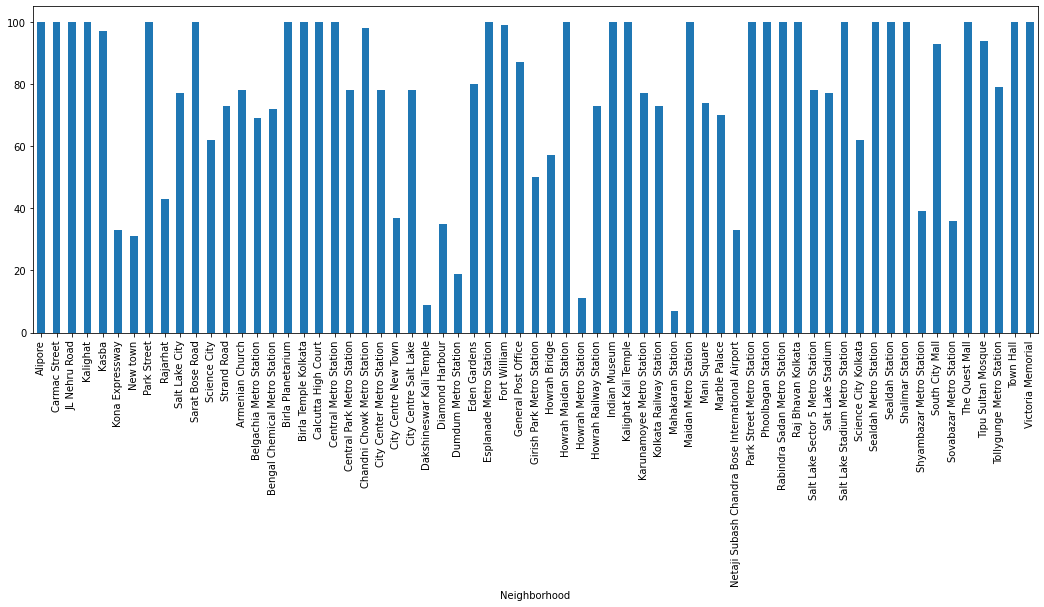

In [15]:
df = kl_venues.groupby(['Neighborhood'], sort=False)['Venue'].count()
df.plot.bar(figsize=(18,6))

The following plot shows only the neighborhoods from which 40 or more than 40 venues were obtained.

<AxesSubplot:xlabel='Neighborhood'>

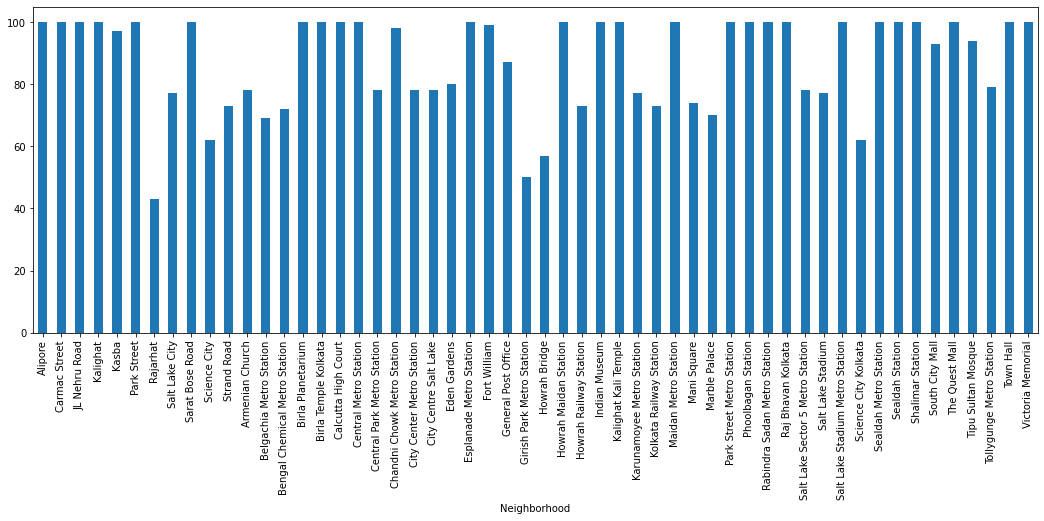

In [16]:
df = df[df >= 40]
df.plot.bar(figsize=(18,6))

Lets create a new dataframe, kl_venues_top that contains only the neighborhoods with 40 and above venues with their details included.

In [17]:
kl_venues_top = kl_venues[kl_venues['Neighborhood'].isin(df.index.tolist())]
kl_venues_top.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alipore,22.5266,88.3351,Taj Bengal,22.537459,88.334066,Hotel
1,Alipore,22.5266,88.3351,Sonargaon,22.537545,88.334210,Indian Restaurant
2,Alipore,22.5266,88.3351,Balwant Singh's Eating House,22.537714,88.344220,Dhaba
3,Alipore,22.5266,88.3351,Jai Hind Dhaba,22.533109,88.353268,Dhaba
4,Alipore,22.5266,88.3351,Tyre Patty,22.538048,88.349169,Café


#### One Hot Encoding


In [18]:

kl_onehot = pd.get_dummies(kl_venues_top['Venue Category'], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
kl_onehot['Neighborhood'] = kl_venues_top['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = kl_onehot.columns.tolist()
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighborhood')))
kl_onehot = kl_onehot.reindex(columns = fixed_columns)

print(kl_onehot.shape)
kl_onehot.head()

(4726, 102)


,Neighborhood,ATM,Airport Lounge,Airport Service,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Awadhi Restaurant,BBQ Joint,...,Sports Club,Stadium,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant
0,Alipore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alipore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alipore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alipore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alipore,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Let's check the number of unique categories and their names of all the venues returned.



In [19]:
print('There are {} unique categories.'.format(len(kl_venues['Venue Category'].unique())))

There are 109 uniques categories.


In [20]:
print('There are {}  categories.'.format(kl_venues['Venue Category'].unique()))

There are ['Hotel' 'Indian Restaurant' 'Dhaba' 'Café' 'Italian Restaurant'
 'Bengali Restaurant' 'Kerala Restaurant' 'History Museum'
 'American Restaurant' 'Frozen Yogurt Shop' 'Field' 'Asian Restaurant'
 'Multiplex' 'Falafel Restaurant' 'Nightclub' 'Chinese Restaurant'
 'Mughlai Restaurant' 'South Indian Restaurant' 'Bakery' 'Coffee Shop'
 'Japanese Restaurant' 'Snack Place' 'Restaurant'
 'Vegetarian / Vegan Restaurant' 'Tex-Mex Restaurant' 'Bookstore'
 'Irish Pub' 'BBQ Joint' 'Shopping Mall' 'Pub' 'Pizza Place' 'Plaza'
 'Hookah Bar' 'Movie Theater' 'Lounge' 'Indian Sweet Shop'
 'Ice Cream Shop' 'Awadhi Restaurant' 'Market' 'Park' 'Gastropub'
 'Arts & Crafts Store' 'Boutique' 'Sports Club' 'Clothing Store'
 'Flea Market' 'Cricket Ground' 'Harbor / Marina' 'Brewery' 'Neighborhood'
 'Department Store' 'Juice Bar' 'Train Station' 'Fast Food Restaurant'
 'Art Museum' 'Mexican Restaurant' 'Fried Chicken Joint' 'Thai Restaurant'
 'Indie Movie Theater' 'Pool' 'Stadium' 'Sandwich Place' 'Tea

Lets group the data by neighborhood and taking the mean value of the frequency of occurrence of each category.

In [21]:
kl_grouped = kl_onehot.groupby('Neighborhood').mean().reset_index()
print(kl_grouped.shape)
kl_grouped

(54, 102)


,Neighborhood,ATM,Airport Lounge,Airport Service,American Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Awadhi Restaurant,BBQ Joint,...,Sports Club,Stadium,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Train Station,Vegetarian / Vegan Restaurant
0,Alipore,0.000000,0.000000,0.000000,0.010000,0.000000,0.010000,0.020000,0.010000,0.010000,...,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000
1,Armenian Church,0.012821,0.000000,0.000000,0.000000,0.012821,0.000000,0.025641,0.000000,0.012821,...,0.000000,0.012821,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.012821,0.000000
2,Belgachia Metro Station,0.014493,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014493,0.028986,0.014493
3,Bengal Chemical Metro Station,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.013889,0.000000,0.000000,0.000000,0.000000,0.013889,0.027778,0.013889
4,Birla Planetarium,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.010000,...,0.010000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
5,Birla Temple Kolkata,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.010000,...,0.010000,0.010000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000
6,Calcutta High Court,0.000000,0.000000,0.000000,0.020000,0.010000,0.000000,0.020000,0.010000,0.010000,...,0.000000,0.010000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000
7,Carmac Street,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.010000,...,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.010000
8,Central Metro Station,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.020000,0.010000,0.010000,...,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.010000,0.000000,0.010000,0.000000
9,Central Park Metro Station,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.012821,0.000000,0.000000,0.000000,0.000000,0.012821,0.012821,0.012821


After removing the neighborhoods with less than 40 venues we are left with 54 neighborhoods and 102 unique categories

In [22]:
kl_grouped.shape

(54, 102)

 The following function returns the top_venues of each neighborhood.

In [24]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets use the above function to obtaine the 10 most common venues in each neighborhood and store in the new pandas dataframe **neighborhoods_venues_sorted**.

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kl_grouped['Neighborhood']

for ind in np.arange(kl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alipore,Café,Chinese Restaurant,Nightclub,Bakery,Indian Restaurant,Bengali Restaurant,Dhaba,Indian Sweet Shop,Lounge,Movie Theater
1,Armenian Church,Indian Restaurant,Café,Mughlai Restaurant,Hotel,Fast Food Restaurant,Indian Sweet Shop,Restaurant,Pub,Platform,Nightclub
2,Belgachia Metro Station,Café,Indian Restaurant,Fast Food Restaurant,Pizza Place,Department Store,Multiplex,Shopping Mall,Bengali Restaurant,Bookstore,Sandwich Place
3,Bengal Chemical Metro Station,Café,Indian Restaurant,Multiplex,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Dhaba,Hotel,Fried Chicken Joint
4,Birla Planetarium,Café,Indian Restaurant,Hotel,Bakery,Nightclub,Mughlai Restaurant,Chinese Restaurant,Multiplex,Indian Sweet Shop,Plaza


**Cluster Neighborhoods**

Here k-Nearest Neighborhoods clustering technique is used. Lets use the silhouette_score to obtain the best value for the number of clusters.

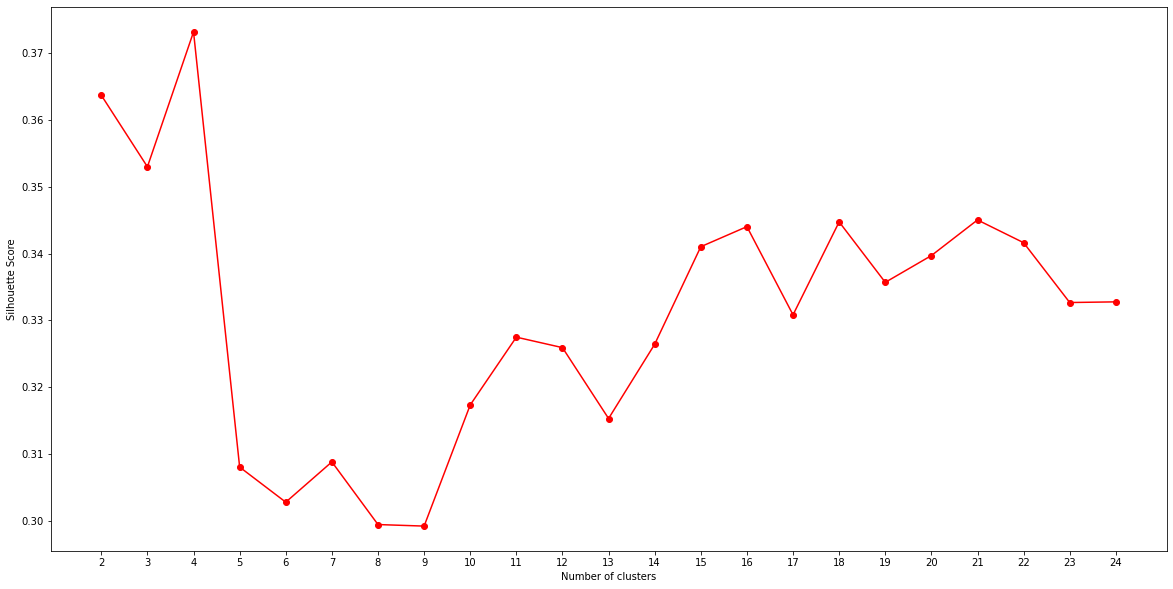

In [26]:
kl_grouped_clustering = kl_grouped.drop('Neighborhood', 1)

max_score = 25
scores = []

for kclusters in range(2, max_score):
    # Run k-means clustering
    kmeans = KMeans(n_clusters = kclusters, init = 'k-means++', random_state = 0).fit_predict(kl_grouped_clustering)
    
    # Gets the silhouette score
    score = silhouette_score(kl_grouped_clustering, kmeans)
    scores.append(score)

plt.figure(figsize=(20,10))
plt.plot(np.arange(2, max_score), scores, 'ro-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.xticks(np.arange(2, max_score))
plt.show()

As seen from the above line plot, the best number of clusters having the **highest silhouette score** is **4**(as the peak is achieved).

In [27]:

kclusters = 4

kl_grouped_clustering = kl_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 2, 2, 0, 3, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 2, 3, 3,
       1, 1, 1, 2, 1, 1, 1, 2, 1, 1], dtype=int32)

Add the cluster labels to the neighborhoods_venues_sorted dataframe. Let's create a new dataframe kl_merged which has the neighborhood details, cluster labels and the 10 most common venues in that neighborhood.

In [28]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kl_merged = kl_venues_top[kl_venues_top.columns[0:3]].drop_duplicates()
kl_merged.reset_index(drop = True, inplace = True)

# merge to add latitude/longitude for each neighborhood
kl_merged = kl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

kl_merged.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alipore,22.526600,88.33510,2,Café,Chinese Restaurant,Nightclub,Bakery,Indian Restaurant,Bengali Restaurant,Dhaba,Indian Sweet Shop,Lounge,Movie Theater
1,Carmac Street,22.546149,88.35288,1,Café,Indian Restaurant,Hotel,Bakery,Nightclub,Mughlai Restaurant,Chinese Restaurant,Indian Sweet Shop,Plaza,Bengali Restaurant
2,JL Nehru Road,22.570610,88.37131,1,Café,Mughlai Restaurant,Indian Restaurant,Hotel,Nightclub,Fast Food Restaurant,Chinese Restaurant,Indian Sweet Shop,Multiplex,Park
3,Kalighat,22.527000,88.34751,2,Café,Indian Restaurant,Nightclub,Bakery,Chinese Restaurant,Mughlai Restaurant,Pizza Place,Hotel,Plaza,Lounge
4,Kasba,22.517280,88.38590,3,Chinese Restaurant,Café,Indian Restaurant,Shopping Mall,Coffee Shop,Hotel,Pizza Place,Park,Multiplex,Indian Sweet Shop


The data type of cluster labels is needed to be converted to int32 so that it can be used to check the clusters

Here we are checking the the number of neighborhoods inside each cluster 

In [31]:

df = kl_merged.copy([['Cluster Labels', 'Neighborhood']])
a = df.groupby(['Cluster Labels'])['Neighborhood'].value_counts()
print(a)

Cluster Labels  Neighborhood                    
0               Belgachia Metro Station             1
                Bengal Chemical Metro Station       1
                Central Park Metro Station          1
                City Center Metro Station           1
                City Centre Salt Lake               1
                Howrah Railway Station              1
                Karunamoyee Metro Station           1
                Kolkata Railway Station             1
                Mani Square                         1
                Phoolbagan Station                  1
                Rajarhat                            1
                Salt Lake City                      1
                Salt Lake Sector 5 Metro Station    1
                Salt Lake Stadium                   1
                Salt Lake Stadium Metro Station     1
1               Armenian Church                     1
                Birla Planetarium                   1
                Birla Temple Kolk

## Results

Let’s examine the clusters and find all the venue categories that distinguish each cluster. Let's also print the ten most common venue category in each cluster.


In [32]:

cluster1 = kl_merged.loc[kl_merged['Cluster Labels'] == 0, kl_merged.columns[[0] + 
                                                                                    list(range(4, kl_merged.shape[1]))]]
venues1 = (cluster1['1st Most Common Venue'].append(
    cluster1['2nd Most Common Venue']).append(
    cluster1['3rd Most Common Venue']).append(
    cluster1['4th Most Common Venue']).append(
    cluster1['5th Most Common Venue']).append(
    cluster1['6th Most Common Venue']).append(
    cluster1['7th Most Common Venue']).append(
    cluster1['8th Most Common Venue']).append(
    cluster1['9th Most Common Venue']).append(
    cluster1['10th Most Common Venue']))

print(venues1.value_counts().head(10))

Pizza Place             15
Café                    15
Fast Food Restaurant    15
Multiplex               15
Indian Restaurant       14
Sandwich Place          11
Fried Chicken Joint     10
Shopping Mall            9
Hotel                    8
Department Store         7
dtype: int64


In [33]:
kl_merged.loc[kl_merged['Cluster Labels'] == 0, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Rajarhat,Pizza Place,Café,Sandwich Place,Hotel,Shopping Mall,Fried Chicken Joint,Fast Food Restaurant,Multiplex,Chinese Restaurant,Bus Station
7,Salt Lake City,Café,Indian Restaurant,Pizza Place,Multiplex,Dhaba,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Bakery,Bengali Restaurant
12,Belgachia Metro Station,Café,Indian Restaurant,Fast Food Restaurant,Pizza Place,Department Store,Multiplex,Shopping Mall,Bengali Restaurant,Bookstore,Sandwich Place
13,Bengal Chemical Metro Station,Café,Indian Restaurant,Multiplex,Pizza Place,Fast Food Restaurant,Chinese Restaurant,Sandwich Place,Dhaba,Hotel,Fried Chicken Joint
18,Central Park Metro Station,Café,Indian Restaurant,Pizza Place,Multiplex,Department Store,Fast Food Restaurant,Fried Chicken Joint,Shopping Mall,Sandwich Place,Hotel
20,City Center Metro Station,Café,Indian Restaurant,Pizza Place,Multiplex,Department Store,Fast Food Restaurant,Fried Chicken Joint,Shopping Mall,Sandwich Place,Bakery
21,City Centre Salt Lake,Café,Indian Restaurant,Pizza Place,Multiplex,Department Store,Fast Food Restaurant,Fried Chicken Joint,Shopping Mall,Sandwich Place,Bakery
29,Howrah Railway Station,Café,Indian Restaurant,Fast Food Restaurant,Department Store,Pizza Place,Multiplex,Shopping Mall,Bookstore,Train Station,Fried Chicken Joint
32,Karunamoyee Metro Station,Café,Indian Restaurant,Pizza Place,Multiplex,Fast Food Restaurant,Fried Chicken Joint,Shopping Mall,Sandwich Place,Dhaba,Convenience Store
33,Kolkata Railway Station,Café,Indian Restaurant,Fast Food Restaurant,Department Store,Pizza Place,Multiplex,Shopping Mall,Bookstore,Train Station,Fried Chicken Joint


In [34]:
cluster2 = kl_merged.loc[kl_merged['Cluster Labels'] == 1, kl_merged.columns[[0] + 
                                                                                    list(range(4, kl_merged.shape[1]))]]
venues2 = (cluster2['1st Most Common Venue'].append(
    cluster2['2nd Most Common Venue']).append(
    cluster2['3rd Most Common Venue']).append(
    cluster2['4th Most Common Venue']).append(
    cluster2['5th Most Common Venue']).append(
    cluster2['6th Most Common Venue']).append(
    cluster2['7th Most Common Venue']).append(
    cluster2['8th Most Common Venue']).append(
    cluster2['9th Most Common Venue']).append(
    cluster2['10th Most Common Venue']))

print(venues2.value_counts().head(10))

Indian Restaurant     30
Mughlai Restaurant    30
Hotel                 30
Café                  30
Nightclub             27
Indian Sweet Shop     26
Bakery                19
Multiplex             18
Chinese Restaurant    14
Pub                   10
dtype: int64


In [35]:
kl_merged.loc[kl_merged['Cluster Labels'] == 1, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Carmac Street,Café,Indian Restaurant,Hotel,Bakery,Nightclub,Mughlai Restaurant,Chinese Restaurant,Indian Sweet Shop,Plaza,Bengali Restaurant
2,JL Nehru Road,Café,Mughlai Restaurant,Indian Restaurant,Hotel,Nightclub,Fast Food Restaurant,Chinese Restaurant,Indian Sweet Shop,Multiplex,Park
5,Park Street,Café,Indian Restaurant,Hotel,Bakery,Chinese Restaurant,Nightclub,Mughlai Restaurant,Indian Sweet Shop,Plaza,Bengali Restaurant
10,Strand Road,Indian Restaurant,Café,Mughlai Restaurant,Hotel,Indian Sweet Shop,Restaurant,Pub,Pizza Place,Plaza,Fast Food Restaurant
11,Armenian Church,Indian Restaurant,Café,Mughlai Restaurant,Hotel,Fast Food Restaurant,Indian Sweet Shop,Restaurant,Pub,Platform,Nightclub
14,Birla Planetarium,Café,Indian Restaurant,Hotel,Bakery,Nightclub,Mughlai Restaurant,Chinese Restaurant,Multiplex,Indian Sweet Shop,Plaza
15,Birla Temple Kolkata,Café,Indian Restaurant,Hotel,Bakery,Nightclub,Mughlai Restaurant,Chinese Restaurant,Multiplex,Indian Sweet Shop,Plaza
16,Calcutta High Court,Café,Indian Restaurant,Nightclub,Hotel,Mughlai Restaurant,Italian Restaurant,Multiplex,Pub,Restaurant,Shopping Mall
17,Central Metro Station,Café,Mughlai Restaurant,Hotel,Indian Restaurant,Nightclub,Restaurant,Indian Sweet Shop,Park,Pub,History Museum
19,Chandni Chowk Metro Station,Café,Indian Restaurant,Mughlai Restaurant,Hotel,Nightclub,Platform,Indian Sweet Shop,Multiplex,Bakery,Park


In [36]:

cluster3 = kl_merged.loc[kl_merged['Cluster Labels'] == 2, kl_merged.columns[[0] + 
                                                                                    list(range(4, kl_merged.shape[1]))]]
venues3 = (cluster3['1st Most Common Venue'].append(
    cluster3['2nd Most Common Venue']).append(
    cluster3['3rd Most Common Venue']).append(
    cluster3['4th Most Common Venue']).append(
    cluster3['5th Most Common Venue']).append(
    cluster3['6th Most Common Venue']).append(
    cluster3['7th Most Common Venue']).append(
    cluster3['8th Most Common Venue']).append(
    cluster3['9th Most Common Venue']).append(
    cluster3['10th Most Common Venue']))

print(venues3.value_counts().head(10))

Café                  6
Chinese Restaurant    6
Indian Restaurant     5
Pizza Place           5
Plaza                 4
Bengali Restaurant    3
Coffee Shop           3
Shopping Mall         3
Bakery                3
Lounge                3
dtype: int64


In [37]:
kl_merged.loc[kl_merged['Cluster Labels'] == 2, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alipore,Café,Chinese Restaurant,Nightclub,Bakery,Indian Restaurant,Bengali Restaurant,Dhaba,Indian Sweet Shop,Lounge,Movie Theater
3,Kalighat,Café,Indian Restaurant,Nightclub,Bakery,Chinese Restaurant,Mughlai Restaurant,Pizza Place,Hotel,Plaza,Lounge
8,Sarat Bose Road,Café,Chinese Restaurant,Shopping Mall,Pizza Place,Bengali Restaurant,Multiplex,Hotel,Plaza,Indian Restaurant,Coffee Shop
31,Kalighat Kali Temple,Café,Chinese Restaurant,Pizza Place,Nightclub,Bakery,Mughlai Restaurant,Clothing Store,Coffee Shop,Indian Restaurant,Lounge
48,South City Mall,Café,Chinese Restaurant,Bengali Restaurant,Plaza,Pizza Place,Clothing Store,Indian Restaurant,Vegetarian / Vegan Restaurant,Shopping Mall,Multiplex
51,Tollygunge Metro Station,Café,Mughlai Restaurant,Chinese Restaurant,Plaza,Shopping Mall,Movie Theater,Pizza Place,Boutique,Dumpling Restaurant,Coffee Shop


In [38]:

cluster4 = kl_merged.loc[kl_merged['Cluster Labels'] == 3, kl_merged.columns[[0] + 
                                                                                    list(range(4, kl_merged.shape[1]))]]
venues4 = (cluster4['1st Most Common Venue'].append(
    cluster4['2nd Most Common Venue']).append(
    cluster4['3rd Most Common Venue']).append(
    cluster4['4th Most Common Venue']).append(
    cluster4['5th Most Common Venue']).append(
    cluster4['6th Most Common Venue']).append(
    cluster4['7th Most Common Venue']).append(
    cluster4['8th Most Common Venue']).append(
    cluster4['9th Most Common Venue']).append(
    cluster4['10th Most Common Venue']))

print(venues4.value_counts().head(10))

Indian Restaurant     3
Indian Sweet Shop     3
Coffee Shop           3
Café                  3
Multiplex             3
Hotel                 3
Chinese Restaurant    3
Mughlai Restaurant    2
Italian Restaurant    2
Bengali Restaurant    2
dtype: int64


In [39]:
kl_merged.loc[kl_merged['Cluster Labels'] == 3, kl_merged.columns[[0] + list(range(4, kl_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Kasba,Chinese Restaurant,Café,Indian Restaurant,Shopping Mall,Coffee Shop,Hotel,Pizza Place,Park,Multiplex,Indian Sweet Shop
9,Science City,Chinese Restaurant,Indian Restaurant,Hotel,Café,Multiplex,Indian Sweet Shop,Bengali Restaurant,Coffee Shop,Italian Restaurant,Mughlai Restaurant
44,Science City Kolkata,Chinese Restaurant,Indian Restaurant,Hotel,Café,Multiplex,Indian Sweet Shop,Bengali Restaurant,Coffee Shop,Italian Restaurant,Mughlai Restaurant


# Deliberation
Let's visulaize the top 5 most common venue categories in each of the cluster

pizza place,multiplex, fast food restaurant,hotel

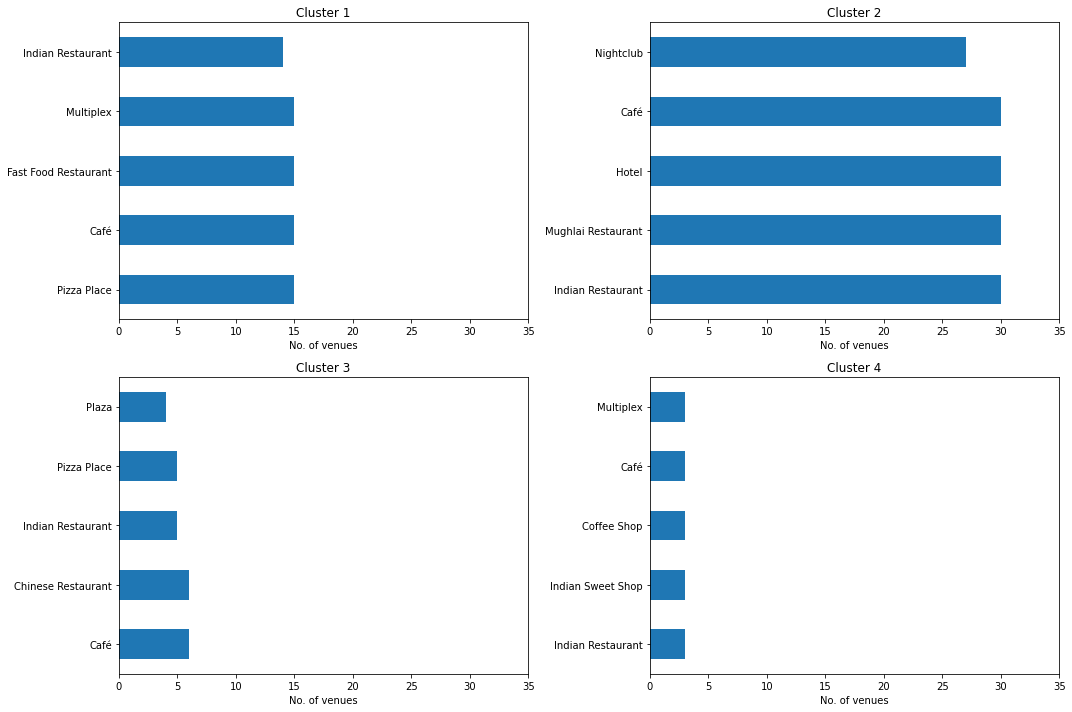

In [43]:
df_list = [venues1 ,venues2, venues3, venues4]
fig, axes = plt.subplots(2, 2)

count = 0
for r in range(2):
    for c in range(2):
        if count!=9:
            df_list[count].value_counts().head().plot.barh(ax = axes[r,c], width=0.5, figsize=(15,10))
            axes[r,c].set_title('Cluster {}'.format(count+1))
            plt.sca(axes[r, c])
            plt.xticks(np.arange(0,40,5))
            plt.xlabel('No. of venues')
            count += 1

# fig.delaxes(ax = ax[0,0]) 
fig.tight_layout()

This plot along with the above allocation and analysis of top 10 venues to cluster is used to suggest valuable information to Business Venturers. 

### Hotels

Cluster 3 and Cluster 4 are the least popular with the lowest number of neighborhoods and venues hence opening a hotel here will not fetch the owner profits 
Out of the most popular clusters i.e, Cluster 1 and Cluster 2, the neighborhoods in cluster 2 has the greatest number of hotels(30), hence opening one here is not the best choice.  
Thus opening a hotel in Cluster 1 is most ideal as it has multiple popular neighborhood options and very few number of hotels(8).     

Potential neighborhoods to open a hotel in Cluster 1 are: Salt Lake City, Belgachia Metro Station,City Center Metro Station,City Centre Salt Lake.  

Alternatively if a quiet and less popular neighborhood is required Cluster 3 can also be suggested as it has multiple neighborhoods and restaurants for potential customer to eat.  
Potential neighborhoods to open a hotel in Cluster 3 are:South City Mall,Tollygunge Metro Station and Alipore

### Fast Food Restaurant

Cluster 3 and Cluster 4 are the least popular with the lowest number of neighborhoods and venues hence opening a fast food restaurant here will not fetch the owner profits 
Out of the most popular clusters i.e, Cluster 1 and Cluster 2, the neighborhoods in cluster 1 has the greatest number of fast food restaurants(15), hence opening one here is not ideal.  
Thus opening a hotel in Cluster 2 is most ideal as it has multiple popular and most neighborhood options and no fast food restaurants.
This rarity of fast food restaurants in such a popular cluster can be utilized by business venturers to maxmize profits.  

Potential Neighborhoods are: Tollygunge Metro Station,Esplanade Metro Station,Fort William

### Pizza Place

Cluster 1 has the most number of Pizza Places, so it doesn't make any sense to open a Pizza Place there.  
However Cluster 2 being the most popular and crowded place among all the clusters, and if it does have any pizza place it will be less than 8.
Hence the most popular place to open a pizza place is Cluster 2.
Alternatively Cluster 3 and Cluster 4 can also be suggested as Cluster  3 has only 5 and Cluster 4 does not have any. But as cluster 4 is the least popular it is probably not a good idea to open it there.

Potential neighborhoods to open:Townhall, Esplanade Metro Station, Fort William

### Multiplex

The most popular clusters are crowded with multiplexes so opening a multiplex there will face a lot of competition.  
Cluster 4 being the least lost popular cluster is still crowded with multiplexes(5).
Hence Cluster 3 is the most suitable to open a multiplex as it is relatively popular than Cluster 4 and even if it has multiplexes then they will be less than 3 therefore it will face less competition.

Potential neighborhoods to open: Tollygunge Metro Station, Kalighat

# Map of Kolkata visualized with clusters

This map can be used to explore all the neighborhoods in the clusters and find a suitable location to start a new business venture based on the category.

In [44]:
# create map
kolkata_clusters_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(kl_merged['Neighborhood Latitude'], kl_merged['Neighborhood Longitude'], kl_merged['Neighborhood'], kl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(kolkata_clusters_map)
       
kolkata_clusters_map